# Module import

In [165]:
from netCDF4 import Dataset                             
import numpy as np            

import matplotlib.pyplot as plt           
import matplotlib.colors as mcolors              
import cartopy.crs as ccrs                              
import cartopy.feature as cfeature     
import cartopy.io.shapereader as shpreader

import sys
import torch 
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta


import os
from scipy.ndimage import gaussian_filter
from matplotlib.colors import ListedColormap

In [166]:
sys.path.append("/home/users/mendrika/Object-Based-LSTMConv/notebooks/model/training")
from ncast import Core2MapModel

# Choose nowcast origin and lead time (in hour)

In [167]:
year = "2020"
month = "09"
day = "05"
hour = "15"
minute = "00"

# Configurations

In [168]:
DISPLAY_LON_MIN = -18.5
DISPLAY_LON_MAX = -4.45
DISPLAY_LAT_MIN = 5.1
DISPLAY_LAT_MAX = 19.5

# Ground truth 

In [169]:
def update_hour(date_dict, hours_to_add, minutes_to_add):
    """
    Add hours and minutes to a datetime dictionary and return the updated dict and a generated file path.

    Args:
        date_dict     (dict): Keys: 'year', 'month', 'day', 'hour', 'minute' as strings, e.g. "01", "23"
        hours_to_add   (int): Number of hours to add.
        minutes_to_add (int): Number of minutes to add.

    Returns:
        tuple:
            - dict: Updated datetime dictionary with all fields as zero-padded strings.
            - str: File path in the format YYYY/MM/YYYYMMDDHHMM.nc
    """
    # Parse the original time
    time_obj = datetime(
        int(date_dict["year"]),
        int(date_dict["month"]),
        int(date_dict["day"]),
        int(date_dict["hour"]),
        int(date_dict["minute"])
    )

    # Add hours
    updated = time_obj + timedelta(hours=hours_to_add, minutes=minutes_to_add)

    # Format updated dictionary
    new_date_dict = {
        "year":   f"{updated.year:04d}",
        "month":  f"{updated.month:02d}",
        "day":    f"{updated.day:02d}",
        "hour":   f"{updated.hour:02d}",
        "minute": f"{updated.minute:02d}"
    }

    # Generate file path
    file_path = f"{new_date_dict['year']}/{new_date_dict['month']}/{new_date_dict['year']}{new_date_dict['month']}{new_date_dict['day']}{new_date_dict['hour']}{new_date_dict['minute']}.nc"

    return {'time': new_date_dict, 'path': file_path}

In [170]:
def load_wavelet_dataset(year, month, day, hour, minute, lead_time):
    
    nowcast_origin = {
        "year":   year,
        "month":  month,
        "day":    day,
        "hour":   hour,
        "minute": minute,
    }

    nowcast_lt = update_hour(nowcast_origin, hours_to_add=lead_time, minutes_to_add=0)["time"]

    path_core = f"/gws/nopw/j04/cocoon/SSA_domain/ch9_wavelet/{nowcast_lt['year']}/{nowcast_lt['month']}"
    file = f"{path_core}/{nowcast_lt['year']}{nowcast_lt['month']}{nowcast_lt['day']}{nowcast_lt['hour']}{nowcast_lt['minute']}.nc"
    return Dataset(file, mode='r')["cores"]

In [171]:
y_min, y_max = 1403, 1914
x_min, x_max = 66, 577

In [172]:
ground_truth_t1 = load_wavelet_dataset(year, month, day, hour, minute, 1)[0, y_min:y_max+1, x_min:x_max+1] != 0
ground_truth_t3 = load_wavelet_dataset(year, month, day, hour, minute, 3)[0, y_min:y_max+1, x_min:x_max+1] != 0
ground_truth_t6 = load_wavelet_dataset(year, month, day, hour, minute, 6)[0, y_min:y_max+1, x_min:x_max+1] != 0

In [173]:
geodata = np.load("/gws/nopw/j04/cocoon/SSA_domain/lat_lon_2268_2080.npz")
lons = geodata["lon"][y_min:y_max+1, x_min:x_max+1]
lats = geodata["lat"][y_min:y_max+1, x_min:x_max+1]

In [174]:
def load_zcast_input(year, month, day, hour, minute, lead_time):
    input_path_zcast = f"/work/scratch-nopw2/mendrika/OB/raw/inputs_t0"
    core_input = f"{input_path_zcast}/input-{year}{month}{day}_{hour}{minute}.pt"
    return torch.load(core_input)

In [175]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [176]:
ENSEMBLE_DIR_T1 = f"/gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/WS/transformer/t1"
ENSEMBLE_DIR_T3 = f"/gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/WS/transformer/t3"
ENSEMBLE_DIR_T6 = f"/gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/WS/transformer/t6"

In [177]:
def load_models(ensemble_dir):
    models = []
    for seed in sorted(os.listdir(ensemble_dir)):
        ckpt = os.path.join(ensemble_dir, seed, "best-core2map.ckpt")
        if os.path.exists(ckpt):
            model = Core2MapModel.load_from_checkpoint(ckpt, map_location=DEVICE)
            model.eval().to(DEVICE)
            models.append(model)
            print(f"Loaded {ckpt}")
    return models

In [178]:
def ensemble_predict(models, x):
    preds = []
    with torch.no_grad():
        for model in models:
            pred = torch.sigmoid(model(x)).squeeze(0).squeeze(0)
            preds.append(pred)
    preds = torch.stack(preds)
    mean_pred = preds.mean(dim=0)
    var_pred  = preds.var(dim=0)
    return mean_pred, var_pred

In [179]:
models_t1 = load_models(ENSEMBLE_DIR_T1)
models_t3 = load_models(ENSEMBLE_DIR_T3)
models_t6 = load_models(ENSEMBLE_DIR_T6)

print(f"Loaded {len(models)} ensemble members.")

Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/WS/transformer/t1/seed10/best-core2map.ckpt
Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/WS/transformer/t1/seed20/best-core2map.ckpt
Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/WS/transformer/t1/seed30/best-core2map.ckpt
Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/WS/transformer/t1/seed40/best-core2map.ckpt
Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/WS/transformer/t1/seed50/best-core2map.ckpt
Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/WS/transformer/t3/seed10/best-core2map.ckpt
Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/WS/transformer/t3/seed20/best-core2map.ckpt
Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/WS/transformer/t3/seed30/best-core2map.ckpt
Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/WS/transformer/t3/seed40/best-core2map.ckpt
Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/WS/t

In [180]:
SCALER_PATH = "/home/users/mendrika/Object-Based-LSTMConv/outputs/scaler/scaler_realcores.pt"

MASK_COL_INDEX = 12
COLS_TO_SCALE = range(4, 12)

# load scaler
scaler = torch.load(SCALER_PATH, weights_only=False)
mean = np.asarray(scaler["mean"])
scale = np.asarray(scaler["scale"])

In [181]:
try:
    # load one instance
    zcast_input = load_zcast_input(year, month, day, hour, minute, lead_time)

    # shape: (5, 50, 13) → add batch dim → (1, 5, 50, 13)
    input_tensor = zcast_input["input_tensor"].clone().unsqueeze(0)

    # remove batch dim for scaling
    X = input_tensor[0]

    # convert to numpy
    X_np = X.numpy()

    # reshape to (250, 13)
    flat = X_np.reshape(-1, X_np.shape[-1])

    # scale all cores (real + padded)
    flat[:, COLS_TO_SCALE] = (flat[:, COLS_TO_SCALE] - mean) / scale

    # reshape back to (5, 50, 13)
    X_scaled = torch.tensor(flat.reshape(X_np.shape), dtype=torch.float32)

    # re-add batch dimension → (1, 5, 50, 13)
    input_scaled = X_scaled.unsqueeze(0)

    mean_pred_t1, _ = ensemble_predict(models_t1, input_scaled.to(DEVICE))
    mean_pred_t3, _ = ensemble_predict(models_t3, input_scaled.to(DEVICE))
    mean_pred_t6, _ = ensemble_predict(models_t6, input_scaled.to(DEVICE))

except:
    print("No data")
    mean_pred_t1 = mean_pred_t3 = mean_pred_t6 =  np.zeros((1, 1, 512, 512))

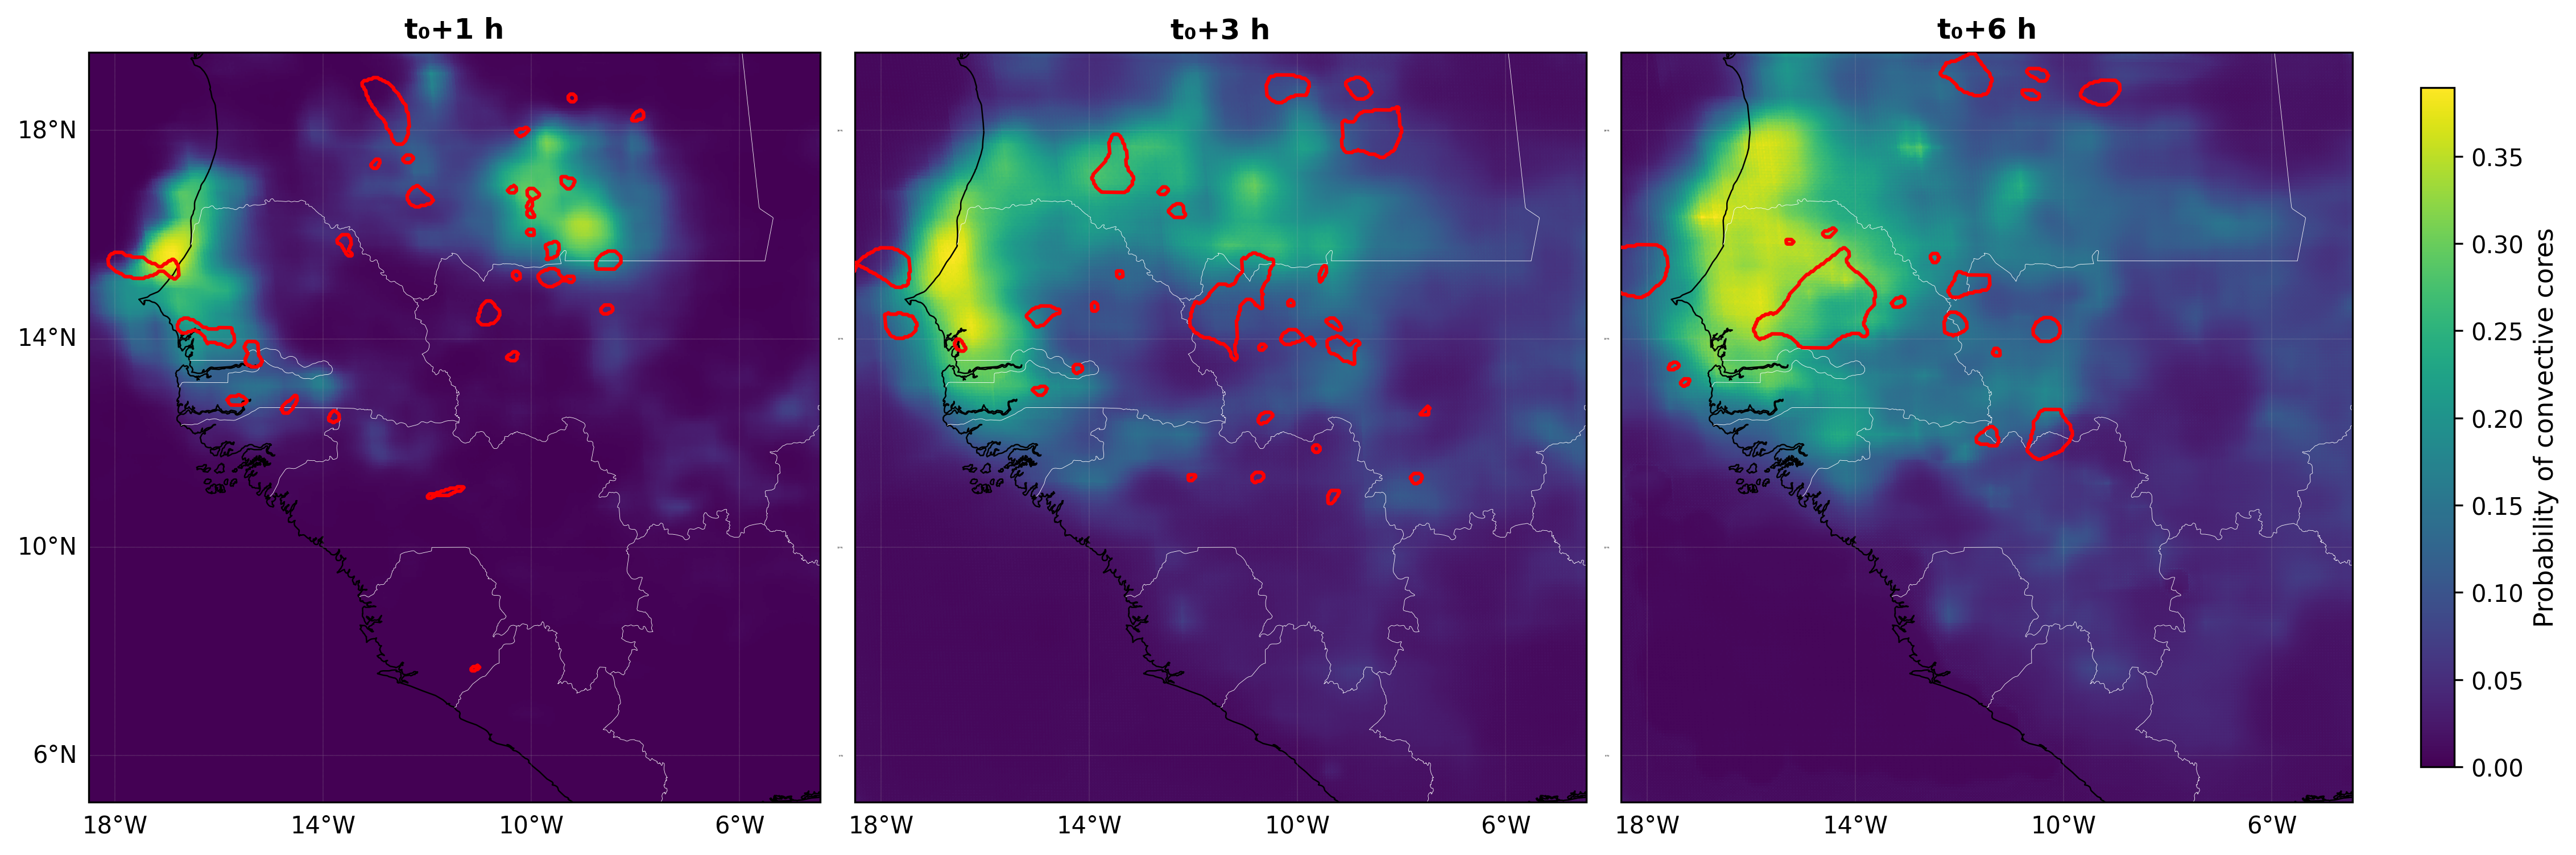

In [182]:
preds = {
    1: mean_pred_t1,
    3: mean_pred_t3,
    6: mean_pred_t6
}

gts = {
    1: ground_truth_t1,
    3: ground_truth_t3,
    6: ground_truth_t6
}

fig, axes = plt.subplots(
    1, 3,
    figsize=(15, 6),
    subplot_kw={'projection': ccrs.PlateCarree()},
    dpi=300,
    constrained_layout=True
)

for idx, lead_time in enumerate([1, 3, 6]):
    ax = axes[idx]

    # ylabel and yticks only for leftmost panel
    if idx == 0:
        ax.set_ylabel("Latitude", fontsize=11)
    else:
        ax.set_ylabel("")
        ax.set_yticks([])

    # simple title
    ax.set_title(f"t₀+{lead_time} h", fontsize=12, weight='bold')

    ax.set_extent(
        [DISPLAY_LON_MIN, DISPLAY_LON_MAX,
         DISPLAY_LAT_MIN, DISPLAY_LAT_MAX],
        crs=ccrs.PlateCarree()
    )

    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='white', linewidth=0.5)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.6)
    ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.2)

    gl = ax.gridlines(
        draw_labels=True, 
        alpha=1, linestyle='--', linewidth=0.1,
        xlocs=np.arange(-18, 6, 4),
        ylocs=np.arange(6, 21, 4),
    )

    gl.top_labels = False
    gl.right_labels = False
    if idx != 0:
        gl.ylabel_style = {'size': 0}

    pred = preds[lead_time]
    gt = gts[lead_time]

    masked = np.ma.masked_where(pred <= 0, pred)

    im = ax.pcolormesh(
        lons, lats, masked.squeeze(),
        cmap='viridis',
        vmin=0,
        vmax=np.max(masked),
        transform=ccrs.PlateCarree(),
        zorder=1
    )

    gt_s = gaussian_filter(gt.astype(float), sigma=0.4)

    ax.contour(
        lons, lats, gt_s,
        levels=[0.5],
        colors='red',
        linewidths=1.5,
        transform=ccrs.PlateCarree(),
        zorder=5
    )

# vertical colourbar on the right-most side
cbar = fig.colorbar(
    im,
    ax=axes,
    orientation='vertical',
    fraction=0.015,     # size of the bar
    pad=0.03           # distance from rightmost panel
)
cbar.set_label('Probability of convective cores', fontsize=11)
plt.show()


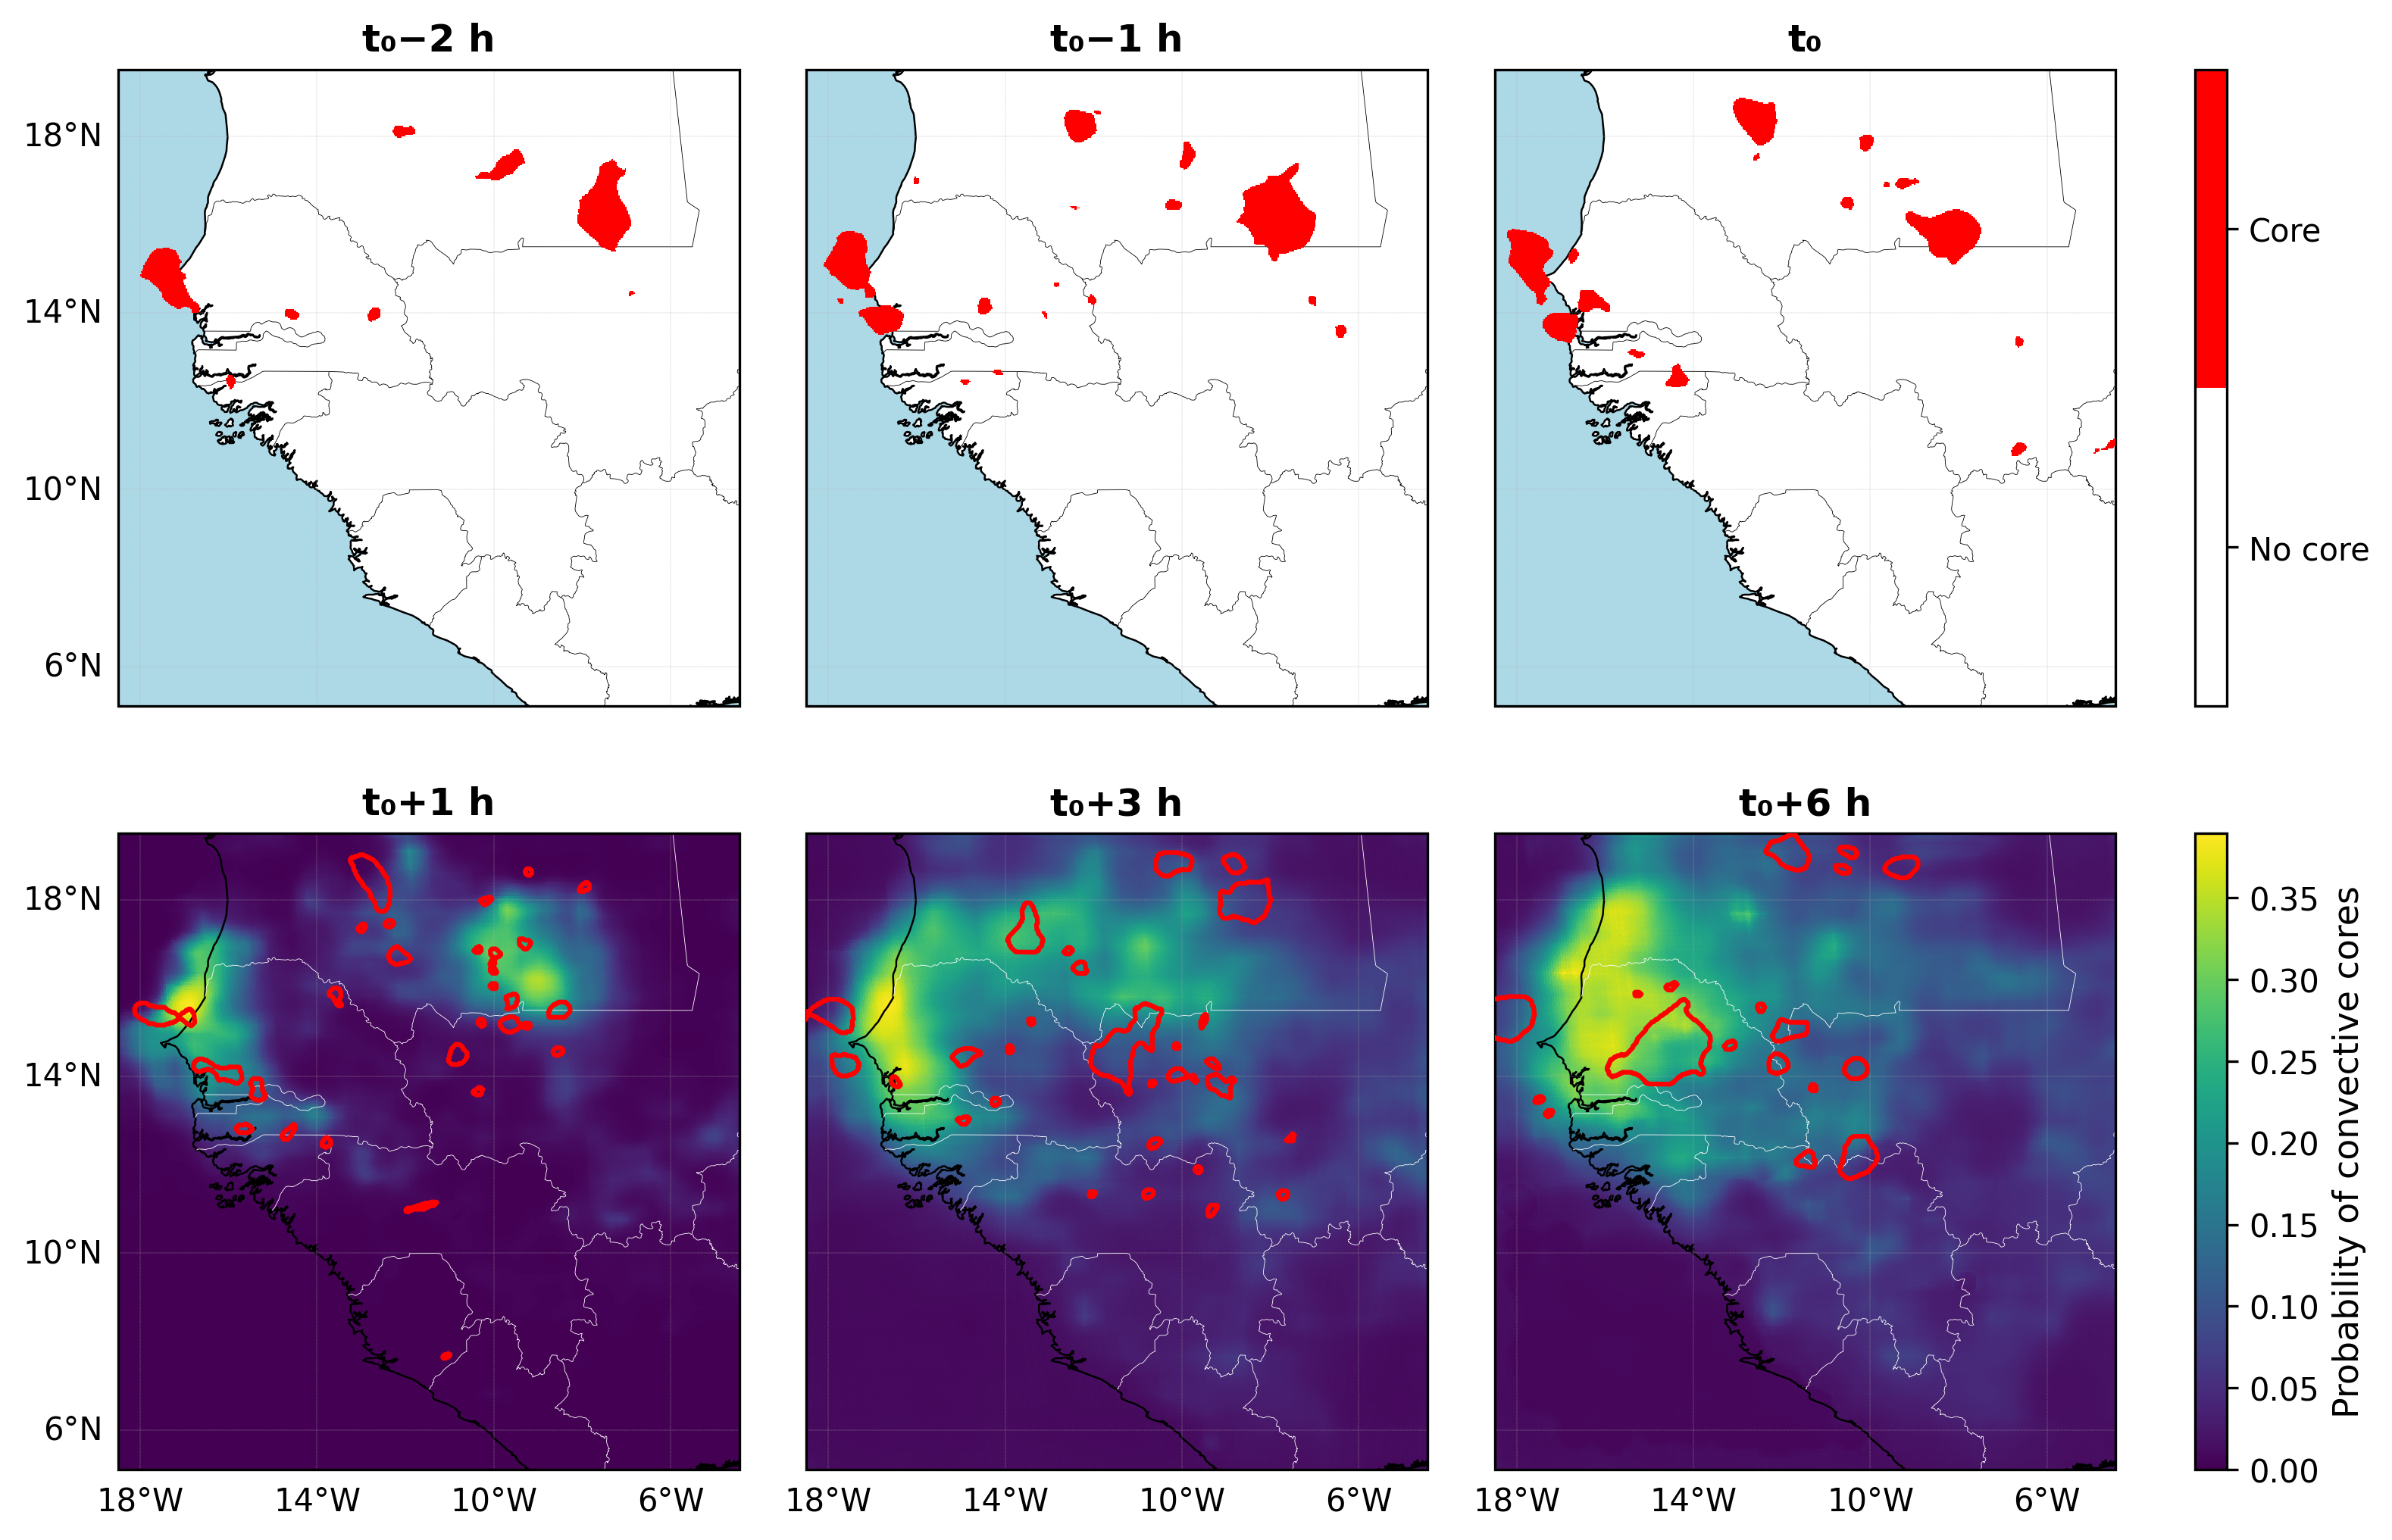

In [183]:
# past frames: boolean masks of cores
inputs = {
    "t₀−2 h": load_wavelet_dataset(year, month, day, hour, minute, -2)[0, y_min:y_max+1, x_min:x_max+1] != 0,
    "t₀−1 h": load_wavelet_dataset(year, month, day, hour, minute, -1)[0, y_min:y_max+1, x_min:x_max+1] != 0,
    "t₀":     load_wavelet_dataset(year, month, day, hour, minute,  0)[0, y_min:y_max+1, x_min:x_max+1] != 0,
}

# nowcasts and ground truth
preds = {
    1: mean_pred_t1,
    3: mean_pred_t3,
    6: mean_pred_t6
}

gts = {
    1: ground_truth_t1,
    3: ground_truth_t3,
    6: ground_truth_t6
}

fig, axes = plt.subplots(
    2, 3,
    figsize=(15, 8),
    subplot_kw={'projection': ccrs.PlateCarree()},
    dpi=300,
    constrained_layout=False
)

fig.subplots_adjust(
    wspace=-0.4,
    hspace=0.2
)

# colormap: transparent for background, red for storms
frame_cmap = ListedColormap([
    (1, 0, 0, 0),    # 0 → transparent
    (1, 0, 0, 1)     # 1 → red
])

# store handle for mask cbar
im_mask = None

# -------------------------
# Row 1: past wavelet cores
# -------------------------
for ax, (title, mask) in zip(axes[0], inputs.items()):

    ax.set_title(title, fontsize=12, weight='bold')
    ax.set_ylabel("")

    ax.set_extent(
        [DISPLAY_LON_MIN, DISPLAY_LON_MAX,
         DISPLAY_LAT_MIN, DISPLAY_LAT_MAX],
        crs=ccrs.PlateCarree()
    )

    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='white', linewidth=0.5)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.6)
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.2)

    gl = ax.gridlines(
        draw_labels=True, 
        alpha=1, linestyle='--', linewidth=0.1,
        xlocs=np.arange(-18, 6, 4),
        ylocs=np.arange(6, 21, 4),
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = False

    if ax is not axes[0][0]:
        gl.left_labels = False

    display = mask.astype(int)

    im_mask = ax.pcolormesh(
        lons,
        lats,
        display,
        cmap=frame_cmap,
        vmin=0,
        vmax=1,
        transform=ccrs.PlateCarree(),
        zorder=5,
    )


# --- colourbar for the past-frame masks (TOP row only) ---
cbar_mask = fig.colorbar(
    im_mask,
    ax=axes[0, :],      # top row only
    orientation='vertical',
    fraction=0.015,
    pad=0.03
)
cbar_mask.set_ticks([0.25, 0.75])
cbar_mask.set_ticklabels(['No core', 'Core'])


# -------------------------
# Row 2: nowcast probabilities
# -------------------------
for idx, lead_time in enumerate([1, 3, 6]):
    ax = axes[1, idx]

    if idx == 0:
        ax.set_ylabel("Latitude", fontsize=11)
    else:
        ax.set_ylabel("")
        ax.set_yticks([])

    ax.set_title(f"t₀+{lead_time} h", fontsize=12, weight='bold')

    ax.set_extent(
        [DISPLAY_LON_MIN, DISPLAY_LON_MAX,
         DISPLAY_LAT_MIN, DISPLAY_LAT_MAX],
        crs=ccrs.PlateCarree()
    )

    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='white', linewidth=0.5)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.6)
    ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.2)

    gl = ax.gridlines(
        draw_labels=True, 
        alpha=1, linestyle='--', linewidth=0.1,
        xlocs=np.arange(-18, 6, 4),
        ylocs=np.arange(6, 21, 4),
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = True

    if idx != 0:
        gl.left_labels = False

    pred = preds[lead_time]
    gt = gts[lead_time]

    masked = np.ma.masked_where(pred <= 0, pred)

    im = ax.pcolormesh(
        lons, lats, masked.squeeze(),
        cmap='viridis',
        vmin=0,
        vmax=np.max(masked),
        transform=ccrs.PlateCarree(),
        zorder=1
    )

    gt_s = gaussian_filter(gt.astype(float), sigma=0.4)

    ax.contour(
        lons, lats, gt_s,
        levels=[0.5],
        colors='red',
        linewidths=1.5,
        transform=ccrs.PlateCarree(),
        zorder=5
    )


# --- colourbar for NOWCASTS (bottom row only) ---
cbar = fig.colorbar(
    im,
    ax=axes[1, :],      # bottom row only
    orientation='vertical',
    fraction=0.015,
    pad=0.03
)
cbar.set_label('Probability of convective cores', fontsize=11)

plt.show()
